In [41]:
# Data load and preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    fbeta_score,
    precision_recall_curve
)
from xgboost import XGBClassifier
import shap


df = pd.read_csv("creditcard.csv")

# Check the schema of the data
df.head()

# Check the types of data
df.info()

# Our target variable is the last one, "Class", which determines if the transaction is fraud or not, i.e, 1 or 0
# Occurrences of fraud vs. non-fraud

occurrences = df['Class'].value_counts()
occurrences

# Ratio of fraudulent cases
ratio = (df["Class"] == 1).sum() / len(df["Class"])
print("Ratio of fraudulent vs. non-fraudulent cases: \n", ratio)

# Features and target variable
X = df.drop(columns=["Class"])
y = df["Class"].values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [42]:
# Split into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [48]:
# XGBOOST
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    random_state=42
)
clf.fit(
    X_train_res, y_train_res,
    eval_set=[(X_valid, y_valid)],
    verbose=False,
)

# Print the classifcation report, confusion matrix, and other metrics
BEST_THR = 0.9201
proba = clf.predict_proba(X_test)[:, 1]
pred  = (proba >= BEST_THR).astype(int)

print("Test ROC-AUC: ", roc_auc_score(y_test, proba))
print("Test PR-AUC:  ", average_precision_score(y_test, proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification report:\n", classification_report(y_test, pred, digits=4))
print("F2 @ chosen threshold:", fbeta_score(y_test, pred, beta=2))


Test ROC-AUC:  0.9775475038910605
Test PR-AUC:   0.841500144450368

Confusion matrix:
 [[42644     4]
 [   13    61]]

Classification report:
               precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     42648
           1     0.9385    0.8243    0.8777        74

    accuracy                         0.9996     42722
   macro avg     0.9691    0.9121    0.9387     42722
weighted avg     0.9996    0.9996    0.9996     42722

F2 @ chosen threshold: 0.8448753462603878


In [ ]:
f2_default = fbeta_score(y_test, pred, beta=2)
print(f"\nF2-score @ threshold=0.5: {f2_default:.4f}")

# --- Find the threshold that maximizes F2 on the test set ---
prec, rec, thr = precision_recall_curve(y_test, proba)
beta = 2
# F_beta from precision/recall sequence
f2_curve = (1 + beta**2) * (prec * rec) / (beta**2 * prec + rec + 1e-12)
best_idx = int(np.nanargmax(f2_curve))
best_thr = thr[best_idx-1] if best_idx > 0 else 0.5  # align with thresholds array length

pred_f2 = (proba >= best_thr).astype(int)
f2_best = fbeta_score(y_test, pred_f2, beta=2)

print(f"Best F2 threshold: {best_thr:.4f}")
print(f"F2-score @ best threshold: {f2_best:.4f}")
print(f"Precision/Recall @ best F2: P={prec[best_idx]:.4f} | R={rec[best_idx]:.4f}")



F2-score @ threshold=0.5: 0.8449
Best F2 threshold: 0.9201
F2-score @ best threshold: 0.8449
Precision/Recall @ best F2: P=0.9531 | R=0.8243

Confusion matrix @ best-F2 threshold:
 [[42644     4]
 [   13    61]]


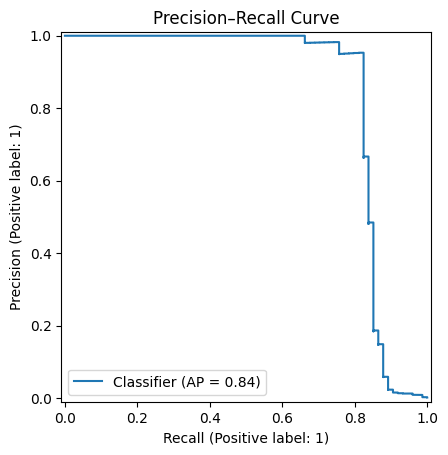

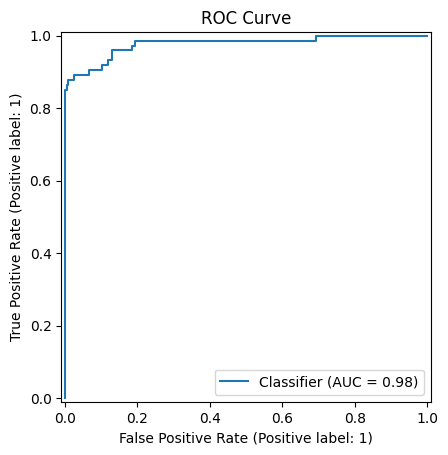

In [45]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title("Precision–Recall Curve")
plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve")
plt.show()

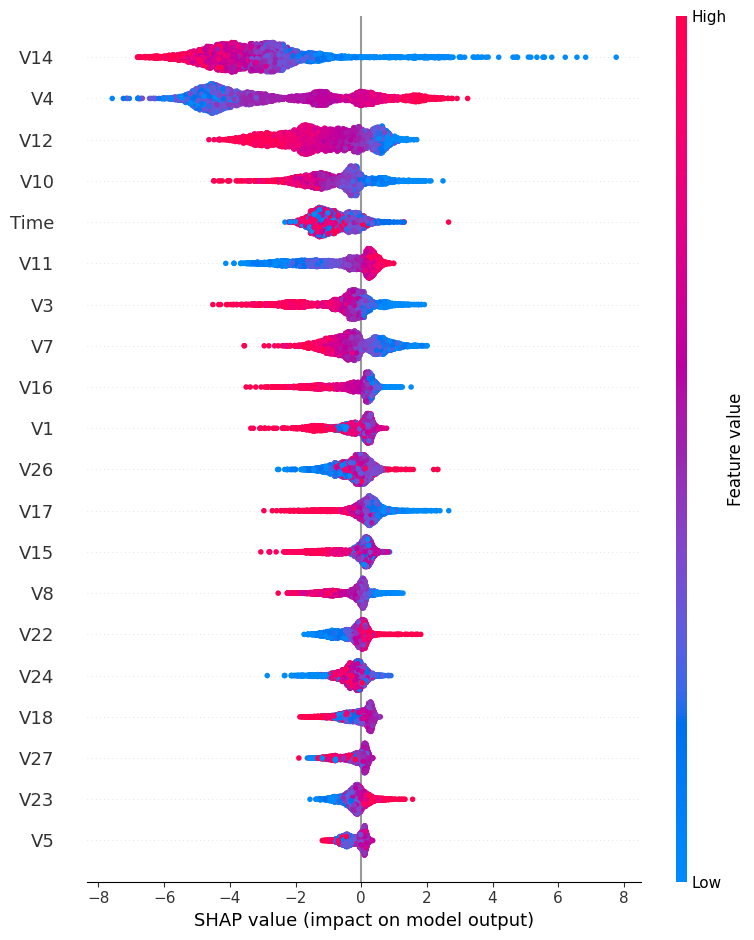

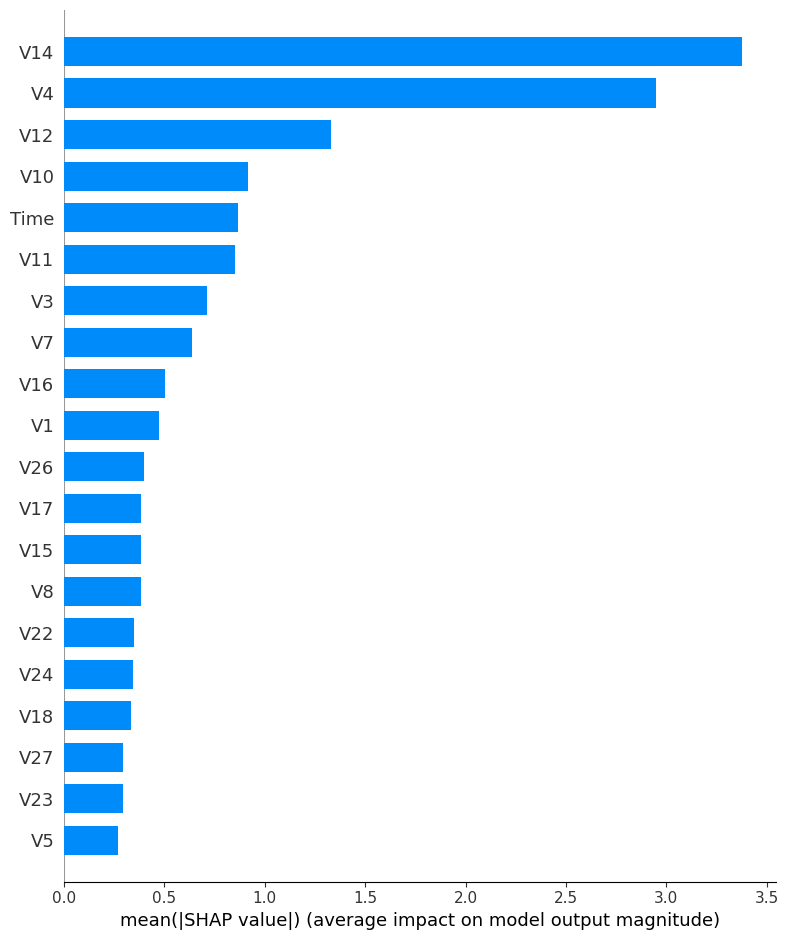

In [49]:
X_test_df = X_test if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test, columns=X.columns)

Xts = X_test_df.sample(n=min(5000, len(X_test_df)), random_state=42)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(Xts)

# Global importance: beeswarm 
shap.summary_plot(shap_values, Xts, plot_type="dot", show=True)

# Global importance: mean 
shap.summary_plot(shap_values, Xts, plot_type="bar", show=True)

idx_top = int(np.argmax(proba))  
x_one = X_test_df.iloc[idx_top:idx_top+1]
sv_one = explainer.shap_values(x_one)


try:
    shap.initjs()
    display(shap.force_plot(explainer.expected_value, sv_one, x_one))
except Exception:
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, sv_one[0], feature_names=x_one.columns.tolist())
